#### This notebook visualizes AORC data and develops eight baselines for the temporal downscaling of the rainfall
##### Author: Omid Emamjomehzadeh (https://www.omidemam.com/)
##### Supervisor: Dr. Omar Wani (https://engineering.nyu.edu/faculty/omar-wani)
##### Hydrologic Systems Group @NYU (https://www.omarwani.com/)

In [43]:
# Load libraries
import os
from PIL import Image
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from glob import glob
from watermark import watermark
import datetime

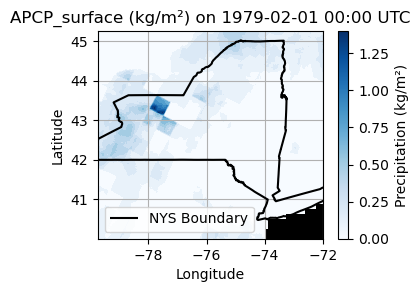

In [10]:
# Load NetCDF file
file_path = r"D:\AORC_NYS_Subsets\Hourly\APCP_surface_1979_19790201_0000.nc"
ds = xr.open_dataset(file_path)
# Extract variable
apcp = ds['APCP_surface']
# Load NYS boundary shapefile
nys_boundary_path = r"D:\hydrological analysis\data\initial layers\state_5070.shp"
nys_boundary = gpd.read_file(nys_boundary_path)
# Match CRS if dataset has projection info (optional, AORC data is lat/lon)
if nys_boundary.crs != "EPSG:4326":
    nys_boundary = nys_boundary.to_crs("EPSG:4326")
# color bar
# Choose a colormap and set NaN (bad) color to black
cmap = plt.get_cmap('Blues').copy()
cmap.set_bad(color='black')
# Plot with NYS overlay
fig, ax = plt.subplots(figsize=(4, 3))
apcp.plot(ax=ax, cmap=cmap, cbar_kwargs={'label': 'Precipitation (kg/m²)'})
nys_boundary.boundary.plot(ax=ax, color='black', linewidth=1.5, label='NYS Boundary')
# Format plot
ax.set_title('APCP_surface (kg/m²) on 1979-02-01 00:00 UTC')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Generate the daily accumulated rainfalls

In [29]:
# Input and output directories
hourly_dir = r"D:\AORC_NYS_Subsets\Hourly"
daily_dir = r"D:\AORC_NYS_Subsets\Daily"
os.makedirs(daily_dir, exist_ok=True)
# Get all hourly files for February 1979
file_list = sorted(glob(os.path.join(hourly_dir, "APCP_surface_1979_197902??_*.nc")))
# Group files by day (extract YYYYMMDD from each filename)
files_by_day = {}
for file in file_list:
    basename = os.path.basename(file)
    parts = basename.split('_')
    date_str = parts[3]  # correct index for "19790201"
    date = pd.to_datetime(date_str, format='%Y%m%d')
    files_by_day.setdefault(date, []).append(file)
# Process each day
for day, files in files_by_day.items():
    files = sorted(files)
    
    # Open and stack all hourly datasets
    datasets = [xr.open_dataset(f) for f in files]
    hourly_data = xr.concat(datasets, dim='time')
    
    # Assign proper time values
    hourly_data['time'] = pd.date_range(start=day, periods=len(files), freq='h')
    
    # Sum over time to get daily accumulated precipitation
    daily_precip = hourly_data['APCP_surface'].sum(dim='time', skipna=False, keep_attrs=True)
    daily_precip = daily_precip.expand_dims(time=[day])
    
    # Save to NetCDF
    out_path = os.path.join(daily_dir, f"APCP_daily_{day.strftime('%Y%m%d')}.nc")
    daily_precip.to_netcdf(out_path)
    
    # Close datasets to release memory
    for ds in datasets:
        ds.close()
    print(f"Saved daily file: {out_path}")

Saved daily file: D:\AORC_NYS_Subsets\Daily\APCP_daily_19790201.nc
Saved daily file: D:\AORC_NYS_Subsets\Daily\APCP_daily_19790202.nc
Saved daily file: D:\AORC_NYS_Subsets\Daily\APCP_daily_19790203.nc
Saved daily file: D:\AORC_NYS_Subsets\Daily\APCP_daily_19790204.nc
Saved daily file: D:\AORC_NYS_Subsets\Daily\APCP_daily_19790205.nc
Saved daily file: D:\AORC_NYS_Subsets\Daily\APCP_daily_19790206.nc
Saved daily file: D:\AORC_NYS_Subsets\Daily\APCP_daily_19790207.nc
Saved daily file: D:\AORC_NYS_Subsets\Daily\APCP_daily_19790208.nc
Saved daily file: D:\AORC_NYS_Subsets\Daily\APCP_daily_19790209.nc
Saved daily file: D:\AORC_NYS_Subsets\Daily\APCP_daily_19790210.nc
Saved daily file: D:\AORC_NYS_Subsets\Daily\APCP_daily_19790211.nc
Saved daily file: D:\AORC_NYS_Subsets\Daily\APCP_daily_19790212.nc
Saved daily file: D:\AORC_NYS_Subsets\Daily\APCP_daily_19790213.nc
Saved daily file: D:\AORC_NYS_Subsets\Daily\APCP_daily_19790214.nc
Saved daily file: D:\AORC_NYS_Subsets\Daily\APCP_daily_1979021

# Baseline 1
#### Conserve the mass with minimum assumption (constant function) 


In [30]:
# Load daily total once
ds_daily = xr.open_dataset(r"D:\AORC_NYS_Subsets\Daily\APCP_daily_19790201.nc")
daily_total = ds_daily["APCP_surface"].squeeze()
# Output directory
output_dir = r"D:\AORC_NYS_Subsets\Baseline 1"
os.makedirs(output_dir, exist_ok=True)
# Create 24 hourly flat maps
for hour in range(24):
    baseline_hour = (daily_total / 24).expand_dims(time=[pd.Timestamp(f"1979-02-01 {hour:02d}:00")])
    out_path = os.path.join(output_dir, f"baseline1_19790201_{hour:02d}00.nc")
    baseline_hour.to_netcdf(out_path)
    print(f"Saved: {out_path}")

Saved: D:\AORC_NYS_Subsets\Baseline 1\baseline1_19790201_0000.nc
Saved: D:\AORC_NYS_Subsets\Baseline 1\baseline1_19790201_0100.nc
Saved: D:\AORC_NYS_Subsets\Baseline 1\baseline1_19790201_0200.nc
Saved: D:\AORC_NYS_Subsets\Baseline 1\baseline1_19790201_0300.nc
Saved: D:\AORC_NYS_Subsets\Baseline 1\baseline1_19790201_0400.nc
Saved: D:\AORC_NYS_Subsets\Baseline 1\baseline1_19790201_0500.nc
Saved: D:\AORC_NYS_Subsets\Baseline 1\baseline1_19790201_0600.nc
Saved: D:\AORC_NYS_Subsets\Baseline 1\baseline1_19790201_0700.nc
Saved: D:\AORC_NYS_Subsets\Baseline 1\baseline1_19790201_0800.nc
Saved: D:\AORC_NYS_Subsets\Baseline 1\baseline1_19790201_0900.nc
Saved: D:\AORC_NYS_Subsets\Baseline 1\baseline1_19790201_1000.nc
Saved: D:\AORC_NYS_Subsets\Baseline 1\baseline1_19790201_1100.nc
Saved: D:\AORC_NYS_Subsets\Baseline 1\baseline1_19790201_1200.nc
Saved: D:\AORC_NYS_Subsets\Baseline 1\baseline1_19790201_1300.nc
Saved: D:\AORC_NYS_Subsets\Baseline 1\baseline1_19790201_1400.nc
Saved: D:\AORC_NYS_Subset

# Baseline 2 
## Using the temporal pattern of region one of the northeastern, the first quantile 10 %


In [6]:
csv_path = r"D:\AORC_NYS_Subsets\rainfall patterns\ne_1_24h_temporal.csv"
# Skip header lines and load 48 rows of data
skip_lines = 9
df = pd.read_csv(csv_path, skiprows=skip_lines, nrows=48)
# Extract column '0.9' and add a zero at the start
values = df['0.9'].astype(float).to_numpy()
values = np.insert(values, 0, 0.0)
# Optional: check result
print(values.shape)
print(values)  # preview first few values
# Create slices for the even-indexed values
v_even_start = values[0:-2:2]  # [v0, v2, v4, ...]
v_even_end   = values[2::2]    # [v2, v4, v6, ...]
# Compute the differences
temp_pater_1 = v_even_end - v_even_start
# Print results
print("Shape:", temp_pater_1.shape)
print("First 5 differences:", temp_pater_1[:5])  # preview first few values

(49,)
[  0.    16.63  32.26  46.23  58.26  68.3   76.43  82.85  87.8   91.52
  94.25  96.2   97.56  98.48  99.08  99.46  99.69  99.83  99.91  99.95
  99.97  99.98  99.99  99.99  99.99  99.99  99.99  99.99  99.99  99.99
  99.99 100.   100.   100.   100.   100.   100.   100.   100.   100.
 100.   100.   100.   100.   100.   100.   100.   100.   100.  ]
Shape: (24,)
First 5 differences: [32.26 26.   18.17 11.37  6.45]


### Apply it to generate hourly precipitation fields for a day

In [7]:
# Load daily total once
ds_daily = xr.open_dataset(r"D:\AORC_NYS_Subsets\Daily\APCP_daily_19790201.nc")
daily_total = ds_daily["APCP_surface"].squeeze()
# Output directory
output_dir = r"D:\AORC_NYS_Subsets\Baseline 2"
os.makedirs(output_dir, exist_ok=True)
# Create 24 hourly flat maps
for i, hour in enumerate(range(24)):
    weight = temp_pater_1[i] / 100
    baseline_hour = (daily_total * weight).expand_dims(time=[pd.Timestamp(f"1979-02-01 {hour:02d}:00")])
    out_path = os.path.join(output_dir, f"baseline2_19790201_{hour:02d}00.nc")
    baseline_hour.to_netcdf(out_path)
    print(f"Saved: {out_path}")

Saved: D:\AORC_NYS_Subsets\Baseline 2\baseline2_19790201_0000.nc
Saved: D:\AORC_NYS_Subsets\Baseline 2\baseline2_19790201_0100.nc
Saved: D:\AORC_NYS_Subsets\Baseline 2\baseline2_19790201_0200.nc
Saved: D:\AORC_NYS_Subsets\Baseline 2\baseline2_19790201_0300.nc
Saved: D:\AORC_NYS_Subsets\Baseline 2\baseline2_19790201_0400.nc
Saved: D:\AORC_NYS_Subsets\Baseline 2\baseline2_19790201_0500.nc
Saved: D:\AORC_NYS_Subsets\Baseline 2\baseline2_19790201_0600.nc
Saved: D:\AORC_NYS_Subsets\Baseline 2\baseline2_19790201_0700.nc
Saved: D:\AORC_NYS_Subsets\Baseline 2\baseline2_19790201_0800.nc
Saved: D:\AORC_NYS_Subsets\Baseline 2\baseline2_19790201_0900.nc
Saved: D:\AORC_NYS_Subsets\Baseline 2\baseline2_19790201_1000.nc
Saved: D:\AORC_NYS_Subsets\Baseline 2\baseline2_19790201_1100.nc
Saved: D:\AORC_NYS_Subsets\Baseline 2\baseline2_19790201_1200.nc
Saved: D:\AORC_NYS_Subsets\Baseline 2\baseline2_19790201_1300.nc
Saved: D:\AORC_NYS_Subsets\Baseline 2\baseline2_19790201_1400.nc
Saved: D:\AORC_NYS_Subset

# Baseline 3
## Using the temporal pattern of region one of the northeastern, the fourth quantile 90 %

In [8]:
csv_path = r"D:\AORC_NYS_Subsets\rainfall patterns\ne_1_24h_temporal.csv"

# Skip header lines and load 48 rows of data
skip_lines = 225
df = pd.read_csv(csv_path, skiprows=skip_lines, nrows=48)
# Extract column '0.9' and add a zero at the start
values = df['0.1'].astype(float).to_numpy()
values = np.insert(values, 0, 0.0)
# Optional: check result
print(values.shape)
print(values)  # preview first few values
# Create slices for the even-indexed values
v_even_start = values[0:-2:2]  # [v0, v2, v4, ...]
v_even_end   = values[2::2]    # [v2, v4, v6, ...]
# Compute the differences
temp_pater_2 = v_even_end - v_even_start
# Print results
print("Shape:", temp_pater_2.shape)
print("First 5 differences:", temp_pater_2[:5])  # preview first few values

(49,)
[  0.     0.29   0.69   1.18   1.69   2.18   2.63   3.08   3.54   4.06
   4.67   5.37   6.19   7.1    8.09   9.14  10.24  11.38  12.56  13.8
  15.11  16.51  18.03  19.69  21.49  23.46  25.58  27.85  30.24  32.76
  35.37  38.08  40.9   43.82  46.88  50.1   53.52  57.14  60.99  65.05
  69.27  73.61  77.97  82.27  86.4   90.3   93.91  97.18 100.  ]
Shape: (24,)
First 5 differences: [0.69 1.   0.94 0.91 1.13]


### Apply it to generate hourly precipitation fields for a day

In [9]:
# Load daily total once
ds_daily = xr.open_dataset(r"D:\AORC_NYS_Subsets\Daily\APCP_daily_19790201.nc")
daily_total = ds_daily["APCP_surface"].squeeze()
# Output directory
output_dir = r"D:\AORC_NYS_Subsets\Baseline 3"
os.makedirs(output_dir, exist_ok=True)
# Create 24 hourly flat maps
for i, hour in enumerate(range(24)):
    weight = temp_pater_2[i] / 100
    baseline_hour = (daily_total * weight).expand_dims(time=[pd.Timestamp(f"1979-02-01 {hour:02d}:00")])
    out_path = os.path.join(output_dir, f"baseline3_19790201_{hour:02d}00.nc")
    baseline_hour.to_netcdf(out_path)
    print(f"Saved: {out_path}")

Saved: D:\AORC_NYS_Subsets\Baseline 3\baseline3_19790201_0000.nc
Saved: D:\AORC_NYS_Subsets\Baseline 3\baseline3_19790201_0100.nc
Saved: D:\AORC_NYS_Subsets\Baseline 3\baseline3_19790201_0200.nc
Saved: D:\AORC_NYS_Subsets\Baseline 3\baseline3_19790201_0300.nc
Saved: D:\AORC_NYS_Subsets\Baseline 3\baseline3_19790201_0400.nc
Saved: D:\AORC_NYS_Subsets\Baseline 3\baseline3_19790201_0500.nc
Saved: D:\AORC_NYS_Subsets\Baseline 3\baseline3_19790201_0600.nc
Saved: D:\AORC_NYS_Subsets\Baseline 3\baseline3_19790201_0700.nc
Saved: D:\AORC_NYS_Subsets\Baseline 3\baseline3_19790201_0800.nc
Saved: D:\AORC_NYS_Subsets\Baseline 3\baseline3_19790201_0900.nc
Saved: D:\AORC_NYS_Subsets\Baseline 3\baseline3_19790201_1000.nc
Saved: D:\AORC_NYS_Subsets\Baseline 3\baseline3_19790201_1100.nc
Saved: D:\AORC_NYS_Subsets\Baseline 3\baseline3_19790201_1200.nc
Saved: D:\AORC_NYS_Subsets\Baseline 3\baseline3_19790201_1300.nc
Saved: D:\AORC_NYS_Subsets\Baseline 3\baseline3_19790201_1400.nc
Saved: D:\AORC_NYS_Subset

# Baseline 4
## Using the temporal pattern of region one of the northeastern, the first quantile 50 %

In [19]:
csv_path = r"D:\AORC_NYS_Subsets\rainfall patterns\ne_1_24h_temporal.csv"
# Skip header lines and load 48 rows of data
skip_lines = 9
df = pd.read_csv(csv_path, skiprows=skip_lines, nrows=48)
# Extract column '0.9' and add a zero at the start
values = df['0.5'].astype(float).to_numpy()
values = np.insert(values, 0, 0.0)
# Optional: check result
print(values.shape)
print(values)  # preview first few values
# Create slices for the even-indexed values
v_even_start = values[0:-2:2]  # [v0, v2, v4, ...]
v_even_end   = values[2::2]    # [v2, v4, v6, ...]
# Compute the differences
temp_pater_3= v_even_end - v_even_start
# Print results
print("Shape:", temp_pater_3.shape)
print("First 5 differences:", temp_pater_3[:5])  

(49,)
[  0.     2.94   7.26  12.37  17.86  23.49  29.09  34.57  39.85  44.88
  49.6   53.98  57.97  61.56  64.72  67.48  69.86  71.9   73.66  75.21
  76.61  77.94  79.25  80.59  81.98  83.44  84.95  86.5   88.05  89.56
  91.    92.33  93.53  94.59  95.51  96.3   96.98  97.57  98.1   98.57
  98.99  99.35  99.64  99.83  99.94  99.98  99.98  99.99 100.  ]
Shape: (24,)
First 5 differences: [ 7.26 10.6  11.23 10.76  9.75]


### Apply it to generate hourly precipitation fields for a day

In [20]:
# Load the daily total once
ds_daily = xr.open_dataset(r"D:\AORC_NYS_Subsets\Daily\APCP_daily_19790201.nc")
daily_total = ds_daily["APCP_surface"].squeeze()
# Output directory
output_dir = r"D:\AORC_NYS_Subsets\Baseline 4"
os.makedirs(output_dir, exist_ok=True)
# Create 24-hour flat maps
for i, hour in enumerate(range(24)):
    weight = temp_pater_3[i] / 100
    baseline_hour = (daily_total * weight).expand_dims(time=[pd.Timestamp(f"1979-02-01 {hour:02d}:00")])
    out_path = os.path.join(output_dir, f"baseline4_19790201_{hour:02d}00.nc")
    baseline_hour.to_netcdf(out_path)
    print(f"Saved: {out_path}")

Saved: D:\AORC_NYS_Subsets\Baseline 4\baseline4_19790201_0000.nc
Saved: D:\AORC_NYS_Subsets\Baseline 4\baseline4_19790201_0100.nc
Saved: D:\AORC_NYS_Subsets\Baseline 4\baseline4_19790201_0200.nc
Saved: D:\AORC_NYS_Subsets\Baseline 4\baseline4_19790201_0300.nc
Saved: D:\AORC_NYS_Subsets\Baseline 4\baseline4_19790201_0400.nc
Saved: D:\AORC_NYS_Subsets\Baseline 4\baseline4_19790201_0500.nc
Saved: D:\AORC_NYS_Subsets\Baseline 4\baseline4_19790201_0600.nc
Saved: D:\AORC_NYS_Subsets\Baseline 4\baseline4_19790201_0700.nc
Saved: D:\AORC_NYS_Subsets\Baseline 4\baseline4_19790201_0800.nc
Saved: D:\AORC_NYS_Subsets\Baseline 4\baseline4_19790201_0900.nc
Saved: D:\AORC_NYS_Subsets\Baseline 4\baseline4_19790201_1000.nc
Saved: D:\AORC_NYS_Subsets\Baseline 4\baseline4_19790201_1100.nc
Saved: D:\AORC_NYS_Subsets\Baseline 4\baseline4_19790201_1200.nc
Saved: D:\AORC_NYS_Subsets\Baseline 4\baseline4_19790201_1300.nc
Saved: D:\AORC_NYS_Subsets\Baseline 4\baseline4_19790201_1400.nc
Saved: D:\AORC_NYS_Subset

# Baseline 5
## Using the temporal pattern of region one of the northeastern, the second quantile 50 %

In [21]:
csv_path = r"D:\AORC_NYS_Subsets\rainfall patterns\ne_1_24h_temporal.csv"
# Skip header lines and load 48 rows of data
skip_lines = 63
df = pd.read_csv(csv_path, skiprows=skip_lines, nrows=48)
# Extract column '0.9' and add a zero at the start
values = df['0.5'].astype(float).to_numpy()
values = np.insert(values, 0, 0.0)
# Optional: check result
print(values.shape)
print(values)  # preview first few values
# Create slices for the even-indexed values
v_even_start = values[0:-2:2]  # [v0, v2, v4, ...]
v_even_end   = values[2::2]    # [v2, v4, v6, ...]
# Compute the differences
temp_pater_4= v_even_end - v_even_start
# Print results
print("Shape:", temp_pater_4.shape)
print("First 5 differences:", temp_pater_4[:5])  

(49,)
[  0.     1.47   2.44   3.48   4.74   6.19   7.78   9.48  11.29  13.28
  15.51  18.07  21.02  24.39  28.19  32.38  36.91  41.69  46.63  51.61
  56.54  61.33  65.88  70.15  74.08  77.64  80.83  83.64  86.09  88.21
  90.03  91.58  92.9   94.03  95.    95.85  96.61  97.29  97.9   98.45
  98.93  99.33  99.63  99.83  99.93  99.96  99.96  99.98 100.  ]
Shape: (24,)
First 5 differences: [2.44 2.3  3.04 3.51 4.22]


### Apply it to generate hourly precipitation fields for a day

In [23]:
# Load the daily total once
ds_daily = xr.open_dataset(r"D:\AORC_NYS_Subsets\Daily\APCP_daily_19790201.nc")
daily_total = ds_daily["APCP_surface"].squeeze()
# Output directory
output_dir = r"D:\AORC_NYS_Subsets\Baseline 5"
os.makedirs(output_dir, exist_ok=True)
# Create 24-hour flat maps
for i, hour in enumerate(range(24)):
    weight = temp_pater_4[i] / 100
    baseline_hour = (daily_total * weight).expand_dims(time=[pd.Timestamp(f"1979-02-01 {hour:02d}:00")])
    out_path = os.path.join(output_dir, f"baseline5_19790201_{hour:02d}00.nc")
    baseline_hour.to_netcdf(out_path)
    print(f"Saved: {out_path}")

Saved: D:\AORC_NYS_Subsets\Baseline 5\baseline5_19790201_0000.nc
Saved: D:\AORC_NYS_Subsets\Baseline 5\baseline5_19790201_0100.nc
Saved: D:\AORC_NYS_Subsets\Baseline 5\baseline5_19790201_0200.nc
Saved: D:\AORC_NYS_Subsets\Baseline 5\baseline5_19790201_0300.nc
Saved: D:\AORC_NYS_Subsets\Baseline 5\baseline5_19790201_0400.nc
Saved: D:\AORC_NYS_Subsets\Baseline 5\baseline5_19790201_0500.nc
Saved: D:\AORC_NYS_Subsets\Baseline 5\baseline5_19790201_0600.nc
Saved: D:\AORC_NYS_Subsets\Baseline 5\baseline5_19790201_0700.nc
Saved: D:\AORC_NYS_Subsets\Baseline 5\baseline5_19790201_0800.nc
Saved: D:\AORC_NYS_Subsets\Baseline 5\baseline5_19790201_0900.nc
Saved: D:\AORC_NYS_Subsets\Baseline 5\baseline5_19790201_1000.nc
Saved: D:\AORC_NYS_Subsets\Baseline 5\baseline5_19790201_1100.nc
Saved: D:\AORC_NYS_Subsets\Baseline 5\baseline5_19790201_1200.nc
Saved: D:\AORC_NYS_Subsets\Baseline 5\baseline5_19790201_1300.nc
Saved: D:\AORC_NYS_Subsets\Baseline 5\baseline5_19790201_1400.nc
Saved: D:\AORC_NYS_Subset

# Baseline 6
## Using the temporal pattern of region one of the northeastern, the third quantile 50 %

In [24]:
csv_path = r"D:\AORC_NYS_Subsets\rainfall patterns\ne_1_24h_temporal.csv"
# Skip header lines and load 48 rows of data
skip_lines = 117
df = pd.read_csv(csv_path, skiprows=skip_lines, nrows=48)
# Extract column '0.9' and add a zero at the start
values = df['0.5'].astype(float).to_numpy()
values = np.insert(values, 0, 0.0)
# Optional: check the result
print(values.shape)
print(values)  # preview first few values
# Create slices for the even-indexed values
v_even_start = values[0:-2:2]  
v_even_end   = values[2::2]    
# Compute the differences
temp_pater_5= v_even_end - v_even_start
# Print results
print("Shape:", temp_pater_5.shape)
print("First 5 differences:", temp_pater_5[:5])  

(49,)
[  0.     1.46   2.47   3.32   4.16   5.07   6.04   7.07   8.15   9.26
  10.39  11.54  12.72  13.94  15.22  16.57  17.99  19.52  21.17  22.96
  24.92  27.07  29.44  32.06  34.97  38.19  41.72  45.56  49.69  54.08
  58.65  63.31  67.99  72.55  76.9   80.93  84.55  87.72  90.41  92.63
  94.43  95.88  97.04  98.    98.78  99.39  99.79  99.96 100.  ]
Shape: (24,)
First 5 differences: [2.47 1.69 1.88 2.11 2.24]


### Apply it to generate hourly precipitation fields for a day

In [26]:
# Load the daily total once
ds_daily = xr.open_dataset(r"D:\AORC_NYS_Subsets\Daily\APCP_daily_19790201.nc")
daily_total = ds_daily["APCP_surface"].squeeze()
# Output directory
output_dir = r"D:\AORC_NYS_Subsets\Baseline 6"
os.makedirs(output_dir, exist_ok=True)
# Create 24-hour flat maps
for i, hour in enumerate(range(24)):
    weight = temp_pater_5[i] / 100
    baseline_hour = (daily_total * weight).expand_dims(time=[pd.Timestamp(f"1979-02-01 {hour:02d}:00")])
    out_path = os.path.join(output_dir, f"baseline6_19790201_{hour:02d}00.nc")
    baseline_hour.to_netcdf(out_path)
    print(f"Saved: {out_path}")

Saved: D:\AORC_NYS_Subsets\Baseline 6\baseline6_19790201_0000.nc
Saved: D:\AORC_NYS_Subsets\Baseline 6\baseline6_19790201_0100.nc
Saved: D:\AORC_NYS_Subsets\Baseline 6\baseline6_19790201_0200.nc
Saved: D:\AORC_NYS_Subsets\Baseline 6\baseline6_19790201_0300.nc
Saved: D:\AORC_NYS_Subsets\Baseline 6\baseline6_19790201_0400.nc
Saved: D:\AORC_NYS_Subsets\Baseline 6\baseline6_19790201_0500.nc
Saved: D:\AORC_NYS_Subsets\Baseline 6\baseline6_19790201_0600.nc
Saved: D:\AORC_NYS_Subsets\Baseline 6\baseline6_19790201_0700.nc
Saved: D:\AORC_NYS_Subsets\Baseline 6\baseline6_19790201_0800.nc
Saved: D:\AORC_NYS_Subsets\Baseline 6\baseline6_19790201_0900.nc
Saved: D:\AORC_NYS_Subsets\Baseline 6\baseline6_19790201_1000.nc
Saved: D:\AORC_NYS_Subsets\Baseline 6\baseline6_19790201_1100.nc
Saved: D:\AORC_NYS_Subsets\Baseline 6\baseline6_19790201_1200.nc
Saved: D:\AORC_NYS_Subsets\Baseline 6\baseline6_19790201_1300.nc
Saved: D:\AORC_NYS_Subsets\Baseline 6\baseline6_19790201_1400.nc
Saved: D:\AORC_NYS_Subset

# Baseline 7
## Using the temporal pattern of region one of the northeastern, the fourth quantile 50 %

In [27]:
csv_path = r"D:\AORC_NYS_Subsets\rainfall patterns\ne_1_24h_temporal.csv"
# Skip header lines and load 48 rows of data
skip_lines = 171
df = pd.read_csv(csv_path, skiprows=skip_lines, nrows=48)
# Extract column '0.9' and add a zero at the start
values = df['0.5'].astype(float).to_numpy()
values = np.insert(values, 0, 0.0)
# Optional: check the result
print(values.shape)
print(values)  # preview first few values
# Create slices for the even-indexed values
v_even_start = values[0:-2:2]  
v_even_end   = values[2::2]    
# Compute the differences
temp_pater_6= v_even_end - v_even_start
# Print results
print("Shape:", temp_pater_6.shape)
print("First 5 differences:", temp_pater_6[:5])  

(49,)
[  0.     1.59   2.91   4.07   5.21   6.41   7.7    9.07  10.48  11.89
  13.24  14.51  15.67  16.73  17.7   18.62  19.52  20.44  21.4   22.43
  23.54  24.74  26.    27.34  28.72  30.13  31.57  33.03  34.52  36.06
  37.68  39.43  41.35  43.5   45.93  48.72  51.89  55.49  59.52  63.96
  68.75  73.79  78.93  83.96  88.63  92.71  95.97  98.33 100.  ]
Shape: (24,)
First 5 differences: [2.91 2.3  2.49 2.78 2.76]


### Apply it to generate hourly precipitation fields for a day

In [28]:
# Load the daily total once
ds_daily = xr.open_dataset(r"D:\AORC_NYS_Subsets\Daily\APCP_daily_19790201.nc")
daily_total = ds_daily["APCP_surface"].squeeze()
# Output directory
output_dir = r"D:\AORC_NYS_Subsets\Baseline 7"
os.makedirs(output_dir, exist_ok=True)
# Create 24-hour flat maps
for i, hour in enumerate(range(24)):
    weight = temp_pater_6[i] / 100
    baseline_hour = (daily_total * weight).expand_dims(time=[pd.Timestamp(f"1979-02-01 {hour:02d}:00")])
    out_path = os.path.join(output_dir, f"baseline7_19790201_{hour:02d}00.nc")
    baseline_hour.to_netcdf(out_path)
    print(f"Saved: {out_path}")

Saved: D:\AORC_NYS_Subsets\Baseline 7\baseline7_19790201_0000.nc
Saved: D:\AORC_NYS_Subsets\Baseline 7\baseline7_19790201_0100.nc
Saved: D:\AORC_NYS_Subsets\Baseline 7\baseline7_19790201_0200.nc
Saved: D:\AORC_NYS_Subsets\Baseline 7\baseline7_19790201_0300.nc
Saved: D:\AORC_NYS_Subsets\Baseline 7\baseline7_19790201_0400.nc
Saved: D:\AORC_NYS_Subsets\Baseline 7\baseline7_19790201_0500.nc
Saved: D:\AORC_NYS_Subsets\Baseline 7\baseline7_19790201_0600.nc
Saved: D:\AORC_NYS_Subsets\Baseline 7\baseline7_19790201_0700.nc
Saved: D:\AORC_NYS_Subsets\Baseline 7\baseline7_19790201_0800.nc
Saved: D:\AORC_NYS_Subsets\Baseline 7\baseline7_19790201_0900.nc
Saved: D:\AORC_NYS_Subsets\Baseline 7\baseline7_19790201_1000.nc
Saved: D:\AORC_NYS_Subsets\Baseline 7\baseline7_19790201_1100.nc
Saved: D:\AORC_NYS_Subsets\Baseline 7\baseline7_19790201_1200.nc
Saved: D:\AORC_NYS_Subsets\Baseline 7\baseline7_19790201_1300.nc
Saved: D:\AORC_NYS_Subsets\Baseline 7\baseline7_19790201_1400.nc
Saved: D:\AORC_NYS_Subset

# Baseline 8
## Using the temporal pattern of region one of the northeastern, all cases 50 %

In [29]:
csv_path = r"D:\AORC_NYS_Subsets\rainfall patterns\ne_1_24h_temporal.csv"
# Skip header lines and load 48 rows of data
skip_lines = 225
df = pd.read_csv(csv_path, skiprows=skip_lines, nrows=48)
# Extract column '0.9' and add a zero at the start
values = df['0.5'].astype(float).to_numpy()
values = np.insert(values, 0, 0.0)
# Optional: check the result
print(values.shape)
print(values)  # preview first few values
# Create slices for the even-indexed values
v_even_start = values[0:-2:2]  
v_even_end   = values[2::2]    
# Compute the differences
temp_pater_7= v_even_end - v_even_start
# Print results
print("Shape:", temp_pater_7.shape)
print("First 5 differences:", temp_pater_7[:5])  

(49,)
[  0.     1.63   3.31   5.     6.73   8.57  10.55  12.67  14.93  17.31
  19.78  22.31  24.89  27.49  30.12  32.79  35.49  38.24  41.05  43.92
  46.84  49.81  52.81  55.82  58.81  61.78  64.69  67.53  70.28  72.94
  75.5   77.96  80.32  82.58  84.75  86.82  88.78  90.63  92.35  93.93
  95.34  96.58  97.63  98.48  99.13  99.59  99.86  99.98 100.  ]
Shape: (24,)
First 5 differences: [3.31 3.42 3.82 4.38 4.85]


### Apply it to generate hourly precipitation fields for a day

In [30]:
# Load the daily total once
ds_daily = xr.open_dataset(r"D:\AORC_NYS_Subsets\Daily\APCP_daily_19790201.nc")
daily_total = ds_daily["APCP_surface"].squeeze()
# Output directory
output_dir = r"D:\AORC_NYS_Subsets\Baseline 8"
os.makedirs(output_dir, exist_ok=True)
# Create 24-hour flat maps
for i, hour in enumerate(range(24)):
    weight = temp_pater_7[i] / 100
    baseline_hour = (daily_total * weight).expand_dims(time=[pd.Timestamp(f"1979-02-01 {hour:02d}:00")])
    out_path = os.path.join(output_dir, f"baseline8_19790201_{hour:02d}00.nc")
    baseline_hour.to_netcdf(out_path)
    print(f"Saved: {out_path}")

Saved: D:\AORC_NYS_Subsets\Baseline 8\baseline8_19790201_0000.nc
Saved: D:\AORC_NYS_Subsets\Baseline 8\baseline8_19790201_0100.nc
Saved: D:\AORC_NYS_Subsets\Baseline 8\baseline8_19790201_0200.nc
Saved: D:\AORC_NYS_Subsets\Baseline 8\baseline8_19790201_0300.nc
Saved: D:\AORC_NYS_Subsets\Baseline 8\baseline8_19790201_0400.nc
Saved: D:\AORC_NYS_Subsets\Baseline 8\baseline8_19790201_0500.nc
Saved: D:\AORC_NYS_Subsets\Baseline 8\baseline8_19790201_0600.nc
Saved: D:\AORC_NYS_Subsets\Baseline 8\baseline8_19790201_0700.nc
Saved: D:\AORC_NYS_Subsets\Baseline 8\baseline8_19790201_0800.nc
Saved: D:\AORC_NYS_Subsets\Baseline 8\baseline8_19790201_0900.nc
Saved: D:\AORC_NYS_Subsets\Baseline 8\baseline8_19790201_1000.nc
Saved: D:\AORC_NYS_Subsets\Baseline 8\baseline8_19790201_1100.nc
Saved: D:\AORC_NYS_Subsets\Baseline 8\baseline8_19790201_1200.nc
Saved: D:\AORC_NYS_Subsets\Baseline 8\baseline8_19790201_1300.nc
Saved: D:\AORC_NYS_Subsets\Baseline 8\baseline8_19790201_1400.nc
Saved: D:\AORC_NYS_Subset

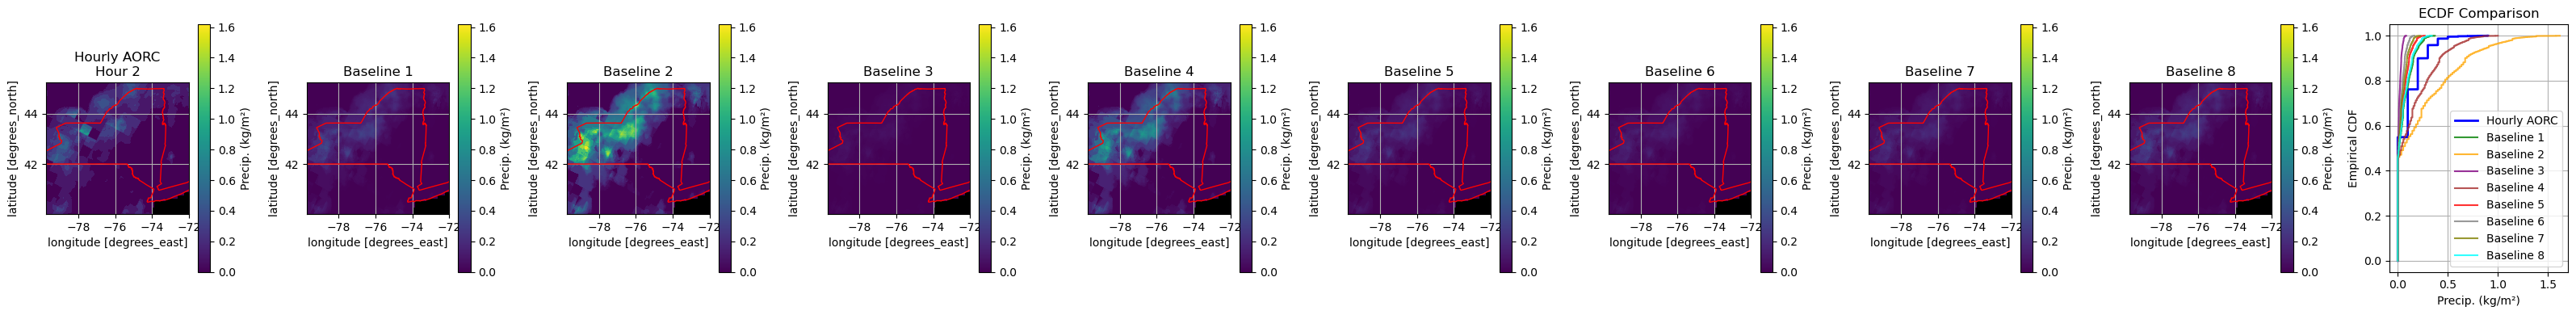

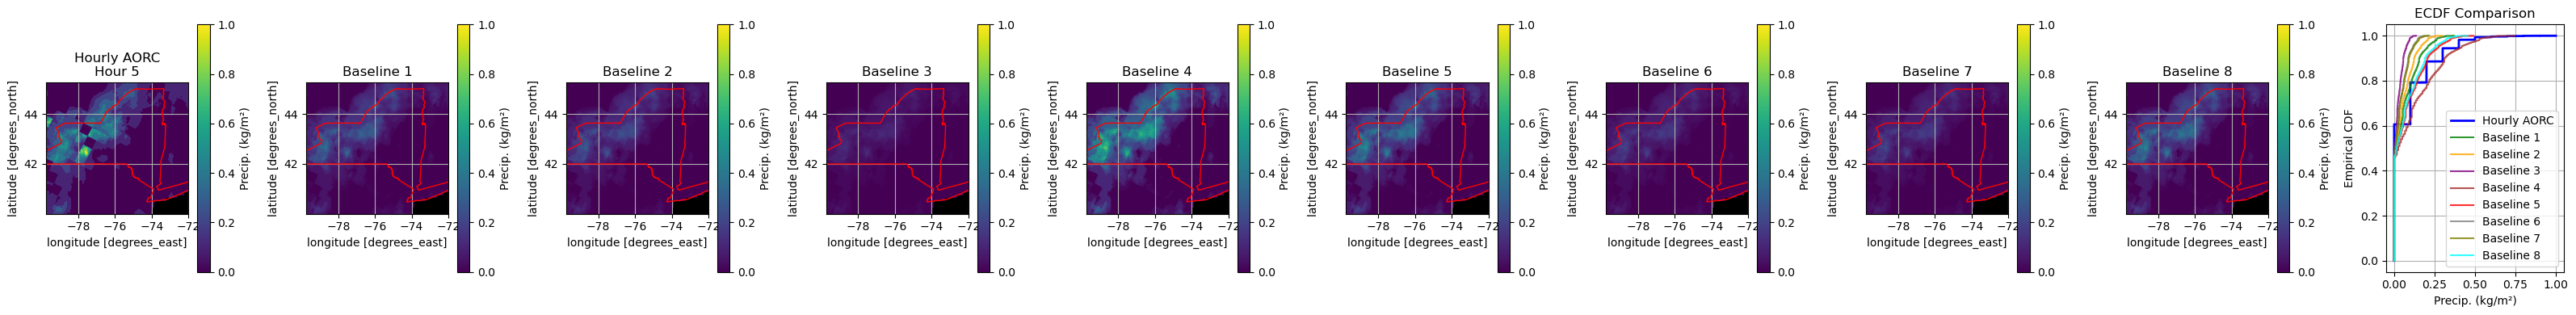

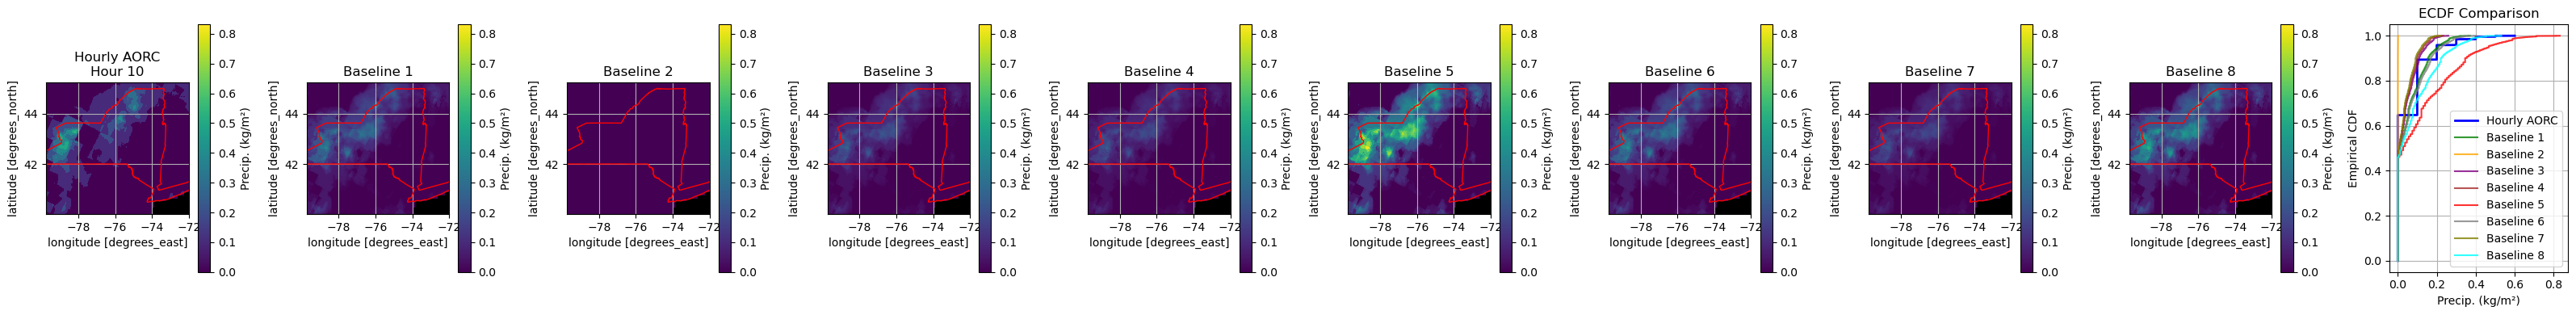

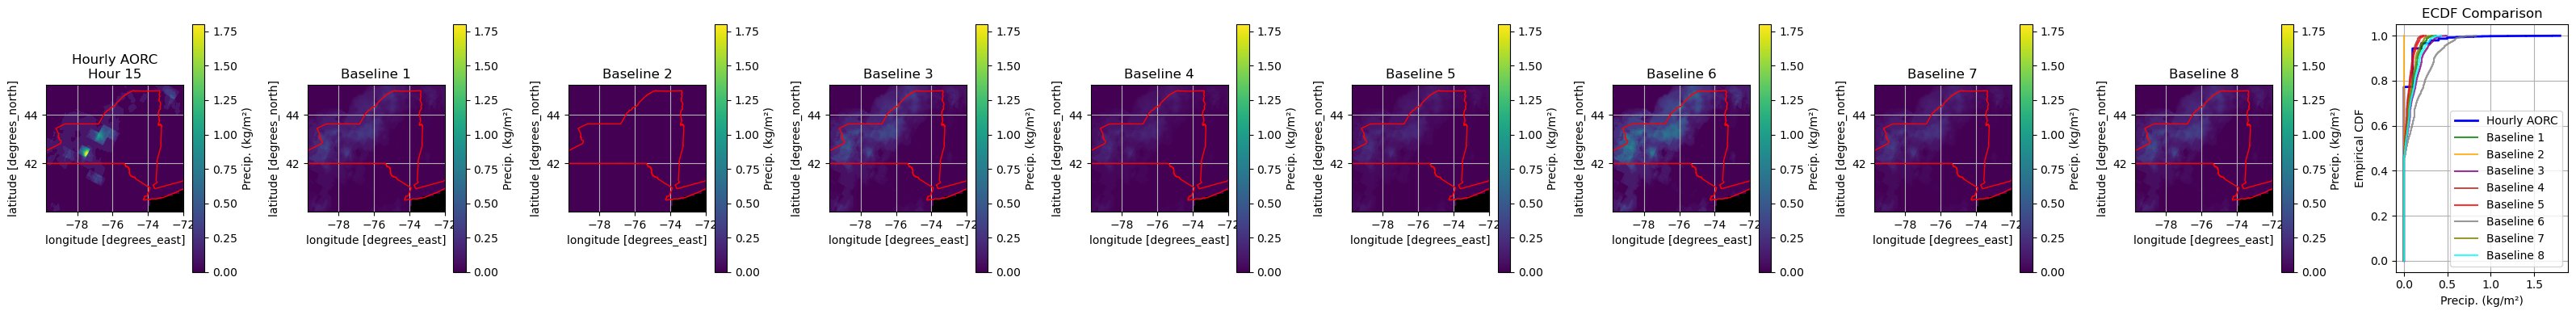

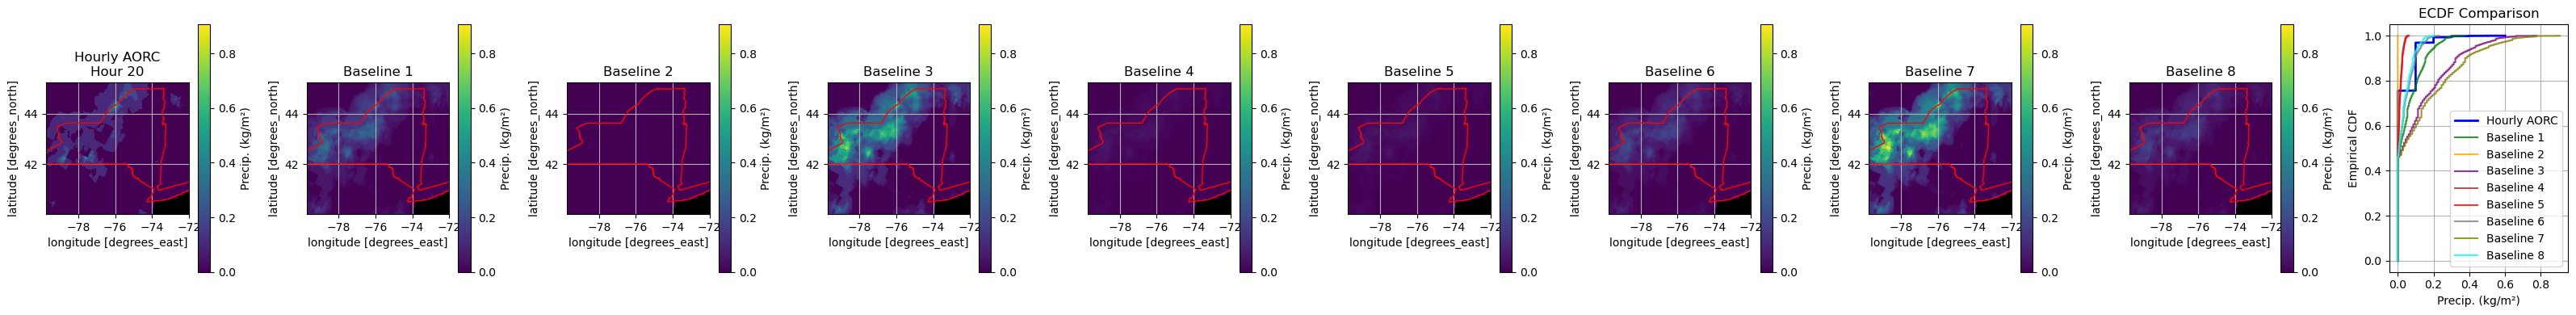

In [31]:
# File paths and setup
hours = [2, 5, 10, 15, 20]
base_path = r"D:\AORC_NYS_Subsets"
shapefile_path = r"D:\hydrological analysis\data\initial layers\state_5070.shp"

# Load NYS boundary
nys_boundary = gpd.read_file(shapefile_path)
if nys_boundary.crs != "EPSG:4326":
    nys_boundary = nys_boundary.to_crs("EPSG:4326")

def compute_ecdf(data):
    data = data[~np.isnan(data)]
    sorted_data = np.sort(data)
    ecdf = np.arange(1, len(sorted_data)+1) / len(sorted_data)
    return sorted_data, ecdf

for hour in hours:
    time_str = f"19790201_{hour:02d}00"
    hourly_file = os.path.join(base_path, "Hourly", f"APCP_surface_1979_{time_str}.nc")
    baseline_files = [
        os.path.join(base_path, f"Baseline {i}", f"baseline{i}_{time_str}.nc") for i in range(1, 9)
    ]

    # Open datasets
    ds_h = xr.open_dataset(hourly_file)
    arr_h = ds_h["APCP_surface"].squeeze()
    vals_h = arr_h.values.flatten()
    x_h, y_h = compute_ecdf(vals_h)

    # Load all baseline arrays and values
    arrs = []
    vals_list = []
    ecdfs = []
    datasets = []
    for i, file in enumerate(baseline_files):
        ds = xr.open_dataset(file)
        datasets.append(ds)
        arr = ds["APCP_surface"].squeeze()
        arrs.append(arr)
        vals = arr.values.flatten()
        vals_list.append(vals)
        ecdfs.append(compute_ecdf(vals))

    # Compute global color limits
    all_arrays = [arr_h] + arrs
    vmin = float(np.nanmin([arr.min() for arr in all_arrays]))
    vmax = float(np.nanmax([arr.max() for arr in all_arrays]))

    # Plot
    n_baselines = len(arrs)
    fig, axes = plt.subplots(ncols=n_baselines + 2, figsize=((n_baselines + 2) * 3.2, 4))

    cmap = plt.get_cmap("viridis").copy()
    cmap.set_bad(color="black")

    # Plot Hourly
    arr_h.plot(ax=axes[0], cmap=cmap, vmin=vmin, vmax=vmax, cbar_kwargs={"label": "Precip. (kg/m²)"})
    nys_boundary.boundary.plot(ax=axes[0], color='red', linewidth=1)
    axes[0].set_title(f"Hourly AORC\nHour {hour}")
    axes[0].grid(True)

    # Plot Baselines
    for i, arr in enumerate(arrs):
        arr.plot(ax=axes[i+1], cmap=cmap, vmin=vmin, vmax=vmax, cbar_kwargs={"label": "Precip. (kg/m²)"})
        nys_boundary.boundary.plot(ax=axes[i+1], color='red', linewidth=1)
        axes[i+1].set_title(f"Baseline {i+1}")
        axes[i+1].grid(True)

    # Plot ECDFs
    axes[-1].plot(x_h, y_h, label="Hourly AORC", color="blue", linewidth=2)
    colors = ["green", "orange", "purple", "brown", "red", "gray", "olive", "cyan"]
    for i, (x_b, y_b) in enumerate(ecdfs):
        axes[-1].plot(x_b, y_b, label=f"Baseline {i+1}", color=colors[i], alpha=0.8)

    axes[-1].set_title("ECDF Comparison")
    axes[-1].set_xlabel("Precip. (kg/m²)")
    axes[-1].set_ylabel("Empirical CDF")
    axes[-1].grid(True)
    axes[-1].legend()

    plt.tight_layout()
    plt.show()

    # Close datasets
    ds_h.close()
    for ds in datasets:
        ds.close()


In [32]:
# File paths and setup
hours = [2, 5, 10, 15, 20]
base_path = r"D:\AORC_NYS_Subsets"
figures_path = os.path.join(base_path, "Figures")
os.makedirs(figures_path, exist_ok=True)

shapefile_path = r"D:\hydrological analysis\data\initial layers\state_5070.shp"
nys_boundary = gpd.read_file(shapefile_path)
if nys_boundary.crs != "EPSG:4326":
    nys_boundary = nys_boundary.to_crs("EPSG:4326")

def compute_ecdf(data):
    data = data[~np.isnan(data)]
    sorted_data = np.sort(data)
    ecdf = np.arange(1, len(sorted_data)+1) / len(sorted_data)
    return sorted_data, ecdf

for hour in hours:
    time_str = f"19790201_{hour:02d}00"
    hourly_file = os.path.join(base_path, "Hourly", f"APCP_surface_1979_{time_str}.nc")
    baseline_files = [
        os.path.join(base_path, f"Baseline {i}", f"baseline{i}_{time_str}.nc") for i in range(1, 9)
    ]

    ds_h = xr.open_dataset(hourly_file)
    arr_h = ds_h["APCP_surface"].squeeze()
    vals_h = arr_h.values.flatten()
    x_h, y_h = compute_ecdf(vals_h)

    arrs, vals_list, ecdfs, datasets = [], [], [], []
    for i, file in enumerate(baseline_files):
        ds = xr.open_dataset(file)
        datasets.append(ds)
        arr = ds["APCP_surface"].squeeze()
        arrs.append(arr)
        vals = arr.values.flatten()
        vals_list.append(vals)
        ecdfs.append(compute_ecdf(vals))

    vmin = float(np.nanmin([arr.min() for arr in [arr_h] + arrs]))
    vmax = float(np.nanmax([arr.max() for arr in [arr_h] + arrs]))

    fig, axes = plt.subplots(ncols=10, figsize=(32, 4))  # 9 maps + 1 ECDF

    cmap = plt.get_cmap("viridis").copy()
    cmap.set_bad(color="black")

    arr_h.plot(ax=axes[0], cmap=cmap, vmin=vmin, vmax=vmax, cbar_kwargs={"label": "Precip. (kg/m²)"})
    nys_boundary.boundary.plot(ax=axes[0], color='red', linewidth=1)
    axes[0].set_title(f"Hourly AORC\nHour {hour}")
    axes[0].grid(True)

    for i, arr in enumerate(arrs):
        arr.plot(ax=axes[i+1], cmap=cmap, vmin=vmin, vmax=vmax, cbar_kwargs={"label": "Precip. (kg/m²)"})
        nys_boundary.boundary.plot(ax=axes[i+1], color='red', linewidth=1)
        axes[i+1].set_title(f"Baseline {i+1}")
        axes[i+1].grid(True)

    axes[-1].plot(x_h, y_h, label="Hourly AORC", color="blue", linewidth=2)
    colors = ["green", "orange", "purple", "brown", "red", "gray", "olive", "cyan"]
    for i, (x_b, y_b) in enumerate(ecdfs):
        axes[-1].plot(x_b, y_b, label=f"Baseline {i+1}", color=colors[i], alpha=0.8)

    axes[-1].set_title("ECDF Comparison")
    axes[-1].set_xlabel("Precip. (kg/m²)")
    axes[-1].set_ylabel("Empirical CDF")
    axes[-1].grid(True)
    axes[-1].legend()

    plt.tight_layout()
    fig_path = os.path.join(figures_path, f"comparison_hour_{hour:02d}.png")
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"Saved: {fig_path}")
    plt.close(fig)

    ds_h.close()
    for ds in datasets:
        ds.close()


Saved: D:\AORC_NYS_Subsets\Figures\comparison_hour_02.png
Saved: D:\AORC_NYS_Subsets\Figures\comparison_hour_05.png
Saved: D:\AORC_NYS_Subsets\Figures\comparison_hour_10.png
Saved: D:\AORC_NYS_Subsets\Figures\comparison_hour_15.png
Saved: D:\AORC_NYS_Subsets\Figures\comparison_hour_20.png


In [34]:
# Directory containing individual figures
figures_path = r"D:\AORC_NYS_Subsets\Figures"
# List of image filenames for each hour in order
image_filenames = [f"comparison_hour_{hour:02d}.png" for hour in [2, 5, 10, 15, 20]]
image_paths = [os.path.join(figures_path, fname) for fname in image_filenames]
# Open all images
images = [Image.open(img_path) for img_path in image_paths]
# Determine total height and max width
total_height = sum(img.height for img in images)
max_width = max(img.width for img in images)
# Create new blank image to stack vertically
combined_img = Image.new("RGB", (max_width, total_height))
# Paste each image
y_offset = 0
for img in images:
    combined_img.paste(img, (0, y_offset))
    y_offset += img.height
# Save the combined image
output_path = os.path.join(figures_path, "merged_comparison_vertical.png")
combined_img.save(output_path)
output_path

'D:\\AORC_NYS_Subsets\\Figures\\merged_comparison_vertical.png'

In [44]:
# Date and time
now = datetime.datetime.now()
print(f"Date and time: {now}")

Date and time: 2025-06-19 19:58:26.069671


In [46]:
%load_ext watermark
# Print Python version and some dependencies
%watermark -v -m -p PIL,xarray,numpy,watermark,matplotlib,geopandas,pandas

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.20.0

PIL       : 10.4.0
xarray    : 2024.7.0
numpy     : 2.0.2
watermark : 2.4.3
matplotlib: 3.8.4
geopandas : 1.0.1
pandas    : 2.2.2

Compiler    : MSC v.1940 64 bit (AMD64)
OS          : Windows
Release     : 11
Machine     : AMD64
Processor   : Intel64 Family 6 Model 183 Stepping 1, GenuineIntel
CPU cores   : 24
Architecture: 64bit

